# Processamento dos dados Raw 

## 0.General imports

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when,array_contains, coalesce, months_between, lit,min, max, to_date, col, sum as spark_sum



## 1. Data load

In [1]:

spark = SparkSession.builder.appName("iFoodCase").getOrCreate()
offers_df = spark.read.json("../data/raw/offers.json")
profile_df = spark.read.json("../data/raw/profile.json")
transactions_df = spark.read.json("../data/raw/transactions.json")

25/04/27 15:27:14 WARN Utils: Your hostname, Giovannas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.49 instead (on interface en0)
25/04/27 15:27:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/27 15:27:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/27 15:27:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:

print(f"Offers partitions: {offers_df.rdd.getNumPartitions()}")
print(f"Profile partitions: {profile_df.rdd.getNumPartitions()}")
print(f"Transactions partitions: {transactions_df.rdd.getNumPartitions()}")

Offers partitions: 1
Profile partitions: 1
Transactions partitions: 4


## 2. Visualizing Data

In [3]:
# Verificando os schemas
print("Schema de offers:")
offers_df.printSchema()

print("\nSchema de profile:")
profile_df.printSchema()

print("\nSchema de transactions:")
transactions_df.printSchema()

Schema de offers:
root
 |-- channels: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- discount_value: long (nullable = true)
 |-- duration: double (nullable = true)
 |-- id: string (nullable = true)
 |-- min_value: long (nullable = true)
 |-- offer_type: string (nullable = true)


Schema de profile:
root
 |-- age: long (nullable = true)
 |-- credit_card_limit: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- id: string (nullable = true)
 |-- registered_on: string (nullable = true)


Schema de transactions:
root
 |-- account_id: string (nullable = true)
 |-- event: string (nullable = true)
 |-- time_since_test_start: double (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- amount: double (nullable = true)
 |    |-- offer id: string (nullable = true)
 |    |-- offer_id: string (nullable = true)
 |    |-- reward: double (nullable = true)



In [4]:
offers_df.show(truncate=False)
profile_df.show(truncate=False)
transactions_df.show(truncate=False)

+----------------------------+--------------+--------+--------------------------------+---------+-------------+
|channels                    |discount_value|duration|id                              |min_value|offer_type   |
+----------------------------+--------------+--------+--------------------------------+---------+-------------+
|[email, mobile, social]     |10            |7.0     |ae264e3637204a6fb9bb56bc8210ddfd|10       |bogo         |
|[web, email, mobile, social]|10            |5.0     |4d5c57ea9a6940dd891ad53e9dbe8da0|10       |bogo         |
|[web, email, mobile]        |0             |4.0     |3f207df678b143eea3cee63160fa8bed|0        |informational|
|[web, email, mobile]        |5             |7.0     |9b98b8c7a33c4b65b9aebfe6a799e6d9|5        |bogo         |
|[web, email]                |5             |10.0    |0b1e1539f2cc45b7b9fa7c272da2e1d7|20       |discount     |
|[web, email, mobile, social]|3             |7.0     |2298d6c36e964ae4a3e7e9706d1fb8c2|7        |discoun

+--------------------------------+--------------+---------------------+----------------------------------------------------+
|account_id                      |event         |time_since_test_start|value                                               |
+--------------------------------+--------------+---------------------+----------------------------------------------------+
|78afa995795e4d85b5d9ceeca43f5fef|offer received|0.0                  |{NULL, 9b98b8c7a33c4b65b9aebfe6a799e6d9, NULL, NULL}|
|a03223e636434f42ac4c3df47e8bac43|offer received|0.0                  |{NULL, 0b1e1539f2cc45b7b9fa7c272da2e1d7, NULL, NULL}|
|e2127556f4f64592b11af22de27a7932|offer received|0.0                  |{NULL, 2906b810c7d4411798c6938adc9daaa5, NULL, NULL}|
|8ec6ce2a7e7949b1bf142def7d0e0586|offer received|0.0                  |{NULL, fafdcd668e3743c1bb461111dcafc2a4, NULL, NULL}|
|68617ca6246f4fbc85e91a2a49552598|offer received|0.0                  |{NULL, 4d5c57ea9a6940dd891ad53e9dbe8da0, NULL, NULL}|


### Inspecting dataframe transactions_df

In [4]:
# Values of event 

transactions_df.select("event").distinct().show(truncate=False)


+---------------+
|event          |
+---------------+
|transaction    |
|offer received |
|offer completed|
|offer viewed   |
+---------------+



Há quatro tipos de eventos. Vamos verificar o conteúdo de value para cada um deles

In [5]:
transactions_only_df = transactions_df.filter(
    col("event") == "transaction"
).select("value.*")

total_rows = transactions_only_df.count()

# Percentual de nulos por coluna
transactions_only_df.select([
    (spark_sum(col(c).isNull().cast("int")) / total_rows * 100).alias(c)
    for c in transactions_only_df.columns
]).show(truncate=False)

+------+--------+--------+------+
|amount|offer id|offer_id|reward|
+------+--------+--------+------+
|0.0   |100.0   |100.0   |100.0 |
+------+--------+--------+------+



In [6]:
offers_received_df = transactions_df.filter(
    col("event") == "offer received"
).select("value.*")

total_rows_offer_received = offers_received_df.count()

# Percentual de nulos por coluna
offers_received_df.select([
    (spark_sum(col(c).isNull().cast("int")) / total_rows_offer_received * 100).alias(c)
    for c in offers_received_df.columns
]).show(truncate=False)

+------+--------+--------+------+
|amount|offer id|offer_id|reward|
+------+--------+--------+------+
|100.0 |0.0     |100.0   |100.0 |
+------+--------+--------+------+



In [7]:
offers_completed_df = transactions_df.filter(
    col("event") == "offer completed"
).select("value.*")

total_rows_offer_completed = offers_completed_df.count()

# Percentual de nulos por coluna
offers_completed_df.select([
    (spark_sum(col(c).isNull().cast("int")) / total_rows_offer_completed * 100).alias(c)
    for c in offers_completed_df.columns
]).show(truncate=False)


+------+--------+--------+------+
|amount|offer id|offer_id|reward|
+------+--------+--------+------+
|100.0 |100.0   |0.0     |0.0   |
+------+--------+--------+------+



Quando event é igual a:
* transaction, em value apenas a informação de amount está preenchida
* offer received, em value apenas a informação de "offer id" está preenchida
* offer completed,em value apenas a informação de "offer_id" e "reward" estão preenchidas

#### Notas:
    1. O dataframe transactions não contém a data da transação e nem da oferta, o que impossibilita utilização de informações históricas de transações para uma oferta recebida, não há chave para cruzamento

#### Inspecionando o dataframe profile_df

In [8]:
# Data de cadastro - verificar o range

profile_df = profile_df.withColumn(
    "registered_on_date",
    to_date(col("registered_on"), "yyyyMMdd")
)

profile_df.select(
    min("registered_on_date").alias("min_registered_on"),
    max("registered_on_date").alias("max_registered_on")
).show()

+-----------------+-----------------+
|min_registered_on|max_registered_on|
+-----------------+-----------------+
|       2013-07-29|       2018-07-26|
+-----------------+-----------------+



Aqui vou assumir que estamos no dia 2018-07-27 para calcular a distribuição em meses da idade da conta

In [9]:
# Calcular idade da conta em meses
profile_df = profile_df.withColumn(
    "account_age_months",
    months_between(lit("2018-07-27"), col("registered_on_date"))
)

In [10]:
percentis = profile_df.approxQuantile("account_age_months", [0.0, 0.25, 0.5, 0.75, 1.0], 0.01)
percentis

[0.03225806, 6.93548387, 11.70967742, 25.58064516, 59.93548387]

Agora vou analisar a coluna age do dataframe profile_df

In [11]:
percentis = profile_df.approxQuantile("age", [0.0, 0.25, 0.5, 0.75, 1.0], 0.01)
percentis

[18.0, 45.0, 58.0, 72.0, 118.0]

In [12]:
profile_df.groupBy("age").count().orderBy("age").show(118)

+---+-----+
|age|count|
+---+-----+
| 18|   70|
| 19|  135|
| 20|  135|
| 21|  140|
| 22|  131|
| 23|  126|
| 24|  139|
| 25|  136|
| 26|  157|
| 27|  139|
| 28|  137|
| 29|  129|
| 30|  131|
| 31|  113|
| 32|  139|
| 33|  152|
| 34|  147|
| 35|  118|
| 36|  175|
| 37|  197|
| 38|  172|
| 39|  182|
| 40|  202|
| 41|  189|
| 42|  227|
| 43|  215|
| 44|  192|
| 45|  231|
| 46|  212|
| 47|  232|
| 48|  288|
| 49|  321|
| 50|  284|
| 51|  363|
| 52|  351|
| 53|  372|
| 54|  359|
| 55|  350|
| 56|  342|
| 57|  353|
| 58|  408|
| 59|  359|
| 60|  333|
| 61|  309|
| 62|  318|
| 63|  338|
| 64|  311|
| 65|  280|
| 66|  284|
| 67|  317|
| 68|  259|
| 69|  242|
| 70|  252|
| 71|  230|
| 72|  191|
| 73|  209|
| 74|  193|
| 75|  159|
| 76|  155|
| 77|  141|
| 78|  135|
| 79|  117|
| 80|  116|
| 81|  118|
| 82|  105|
| 83|  102|
| 84|   83|
| 85|   70|
| 86|   54|
| 87|   66|
| 88|   64|
| 89|   53|
| 90|   52|
| 91|   47|
| 92|   40|
| 93|   29|
| 94|   33|
| 95|   22|
| 96|    8|
| 97|   13|
| 98

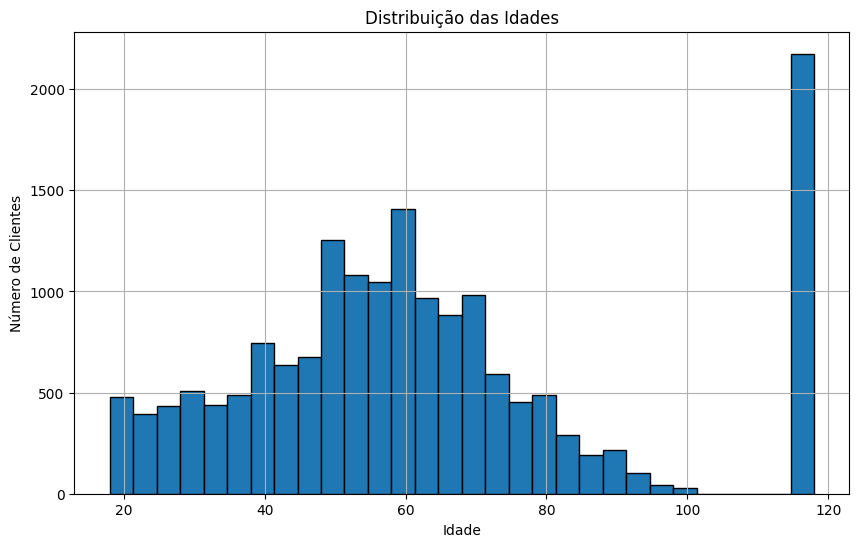

In [13]:
import matplotlib.pyplot as plt

ages = profile_df.select("age").dropna().rdd.flatMap(lambda x: x).collect()


# Plotar histograma
plt.figure(figsize=(10,6))
plt.hist(ages, bins=30, edgecolor="black")  # Você pode ajustar o número de bins se quiser
plt.title("Distribuição das Idades")
plt.xlabel("Idade")
plt.ylabel("Número de Clientes")
plt.grid(True)
plt.show()

In [13]:
# Verificando a questão de idades com valor 118 e alta média de idades

profile_df.filter(col("age") == 118).count()


2175

In [14]:
profile_df.filter(col("age").isNull()).count()


0

**Vou considerar aqui a idade 118 representando missings**

## Preparação do Dataframe para treino

#### Unificação do offer id

In [15]:
# Criando uma nova coluna a partir do coalesce dos offer id's

transactions_df = transactions_df.withColumn(
    "offer_id_cleaned",
    coalesce(col("value.offer_id"), col("value.`offer id`"))
)

#### Tranformando a idade 118 em None

In [16]:
profile_df = profile_df.withColumn(
    "age",
    when(col("age") == 118, None).otherwise(col("age"))
)

#### Criando dataframes separados por tipo de transação 

Vou horizontalizar a tabela de ofertas recebidas cruzando a o status completed, que será a target do modelo

In [17]:
# Separar o dataframe transactions e uní-los posteriormente

# Separar ofertas recebidas
received_df = transactions_df.filter(col("event") == "offer received")

# Separar ofertas visualizadas
# viewed_df = transactions_df.filter(col("event") == "offer viewed")

# Separar ofertas completadas
completed_df = transactions_df.filter(col("event") == "offer completed")

# Separar transações normais
# purchases_df = transactions_df.filter(col("event") == "transaction")

In [18]:
print(f"Ofertas recebidas: {received_df.count()}")
# print(f"Ofertas visualizadas: {viewed_df.count()}")
print(f"Ofertas completadas: {completed_df.count()}")
# print(f"Compras normais: {purchases_df.count()}")

Ofertas recebidas: 76277


Ofertas completadas: 33579


In [15]:
# Verificando se as ofertas são necessariamente recebidas em time_since_test_start = 0
# received_df.select("time_since_test_start").distinct().orderBy("time_since_test_start").show(100)


Agora vou preparar a base de ofertas recebidas para cruzar a base de ofertas recebidas com a base de ofertas completadas

In [19]:
# Agora vou preparar a base de ofertas recebidas para cruzar a base de ofertas recebidas com a base de ofertas completadas

offers_base_df = received_df.select(
    col("account_id"),
    col("offer_id_cleaned"),
    col("time_since_test_start").alias("offer_received_time")
)

Aqui vou criar a target "completed"

In [20]:
from pyspark.sql.functions import lit, when, col

completed_flags_df = completed_df.select(
    col("account_id").alias("completed_account_id"),
    col("offer_id_cleaned").alias("completed_offer_id")
).withColumn("completed", lit(1))

In [21]:

# Juntar offers_base_df com completed
offers_base_df = offers_base_df.join(
    completed_flags_df,
    (offers_base_df.account_id == completed_flags_df.completed_account_id) & 
    (offers_base_df.offer_id_cleaned == completed_flags_df.completed_offer_id),
    how="left"
).drop("completed_account_id", "completed_offer_id")

# Preencher nulos na target

offers_base_df = offers_base_df.withColumn("completed", when(col("completed").isNull(), 0).otherwise(1))

offers_base_df.show(10, truncate=False)



+--------------------------------+--------------------------------+-------------------+---------+
|account_id                      |offer_id_cleaned                |offer_received_time|completed|
+--------------------------------+--------------------------------+-------------------+---------+
|2eeac8d8feae4a8cad5a6af0499a211d|3f207df678b143eea3cee63160fa8bed|0.0                |0        |
|31dda685af34476cad5bc968bdb01c53|0b1e1539f2cc45b7b9fa7c272da2e1d7|0.0                |0        |
|389bc3fa690240e798340f5a15918d5c|f19421c1d4aa40978ebb69ca19b0e20d|0.0                |1        |
|389bc3fa690240e798340f5a15918d5c|f19421c1d4aa40978ebb69ca19b0e20d|0.0                |1        |
|68617ca6246f4fbc85e91a2a49552598|4d5c57ea9a6940dd891ad53e9dbe8da0|0.0                |0        |
|744d603ef08c4f33af5a61c8c7628d1c|0b1e1539f2cc45b7b9fa7c272da2e1d7|0.0                |0        |
|78afa995795e4d85b5d9ceeca43f5fef|9b98b8c7a33c4b65b9aebfe6a799e6d9|0.0                |1        |
|8ec6ce2a7e7949b1bf1

#### Removendo duplicidades do dataframe

In [22]:
offers_base_df = offers_base_df.dropDuplicates()

#### Juntar informações dos clientes ao Master Table (offers_base_df)

Cria variavel de idade da conta em meses

In [23]:
from pyspark.sql.functions import months_between, lit

profile_df = profile_df.withColumn(
    "registered_on_date",
    to_date(col("registered_on"), "yyyyMMdd")
)

profile_df.select(
    min("registered_on_date").alias("min_registered_on"),
    max("registered_on_date").alias("max_registered_on")
).show()

# Calcular idade da conta em meses
profile_df = profile_df.withColumn(
    "account_age_months",
    months_between(lit("2018-07-27"), col("registered_on_date"))
)

+-----------------+-----------------+
|min_registered_on|max_registered_on|
+-----------------+-----------------+
|       2013-07-29|       2018-07-26|
+-----------------+-----------------+



Junção da base dos clientes com a base de ofertas recebidas

In [24]:
offers_base_df = offers_base_df.join(
    profile_df,
    offers_base_df.account_id == profile_df.id,
    how="left"
).drop(profile_df.id)

Criação de variável categórica de faixa de idade

In [25]:
# from pyspark.sql.functions import when

offers_base_df = offers_base_df.withColumn(
    "age_group",
    when(col("age").isNull(), "unknown")
    .when(col("age") <= 25, "18-25")
    .when((col("age") > 25) & (col("age") <= 35), "26-35")
    .when((col("age") > 35) & (col("age") <= 45), "36-45")
    .when((col("age") > 45) & (col("age") <= 55), "46-55")
    .when((col("age") > 55) & (col("age") <= 65), "56-65")
    .otherwise("66+")
)

In [26]:
offers_base_df.show(10, truncate=False)


+--------------------------------+--------------------------------+-------------------+---------+----+-----------------+------+-------------+------------------+------------------+---------+
|account_id                      |offer_id_cleaned                |offer_received_time|completed|age |credit_card_limit|gender|registered_on|registered_on_date|account_age_months|age_group|
+--------------------------------+--------------------------------+-------------------+---------+----+-----------------+------+-------------+------------------+------------------+---------+
|0861b9ca31b741bb8b411b18f82d18f6|f19421c1d4aa40978ebb69ca19b0e20d|0.0                |1        |73  |92000.0          |M     |20170627     |2017-06-27        |13.0              |66+      |
|0485b8cb0bfc4d938895bbd6d8cbd7df|2906b810c7d4411798c6938adc9daaa5|0.0                |0        |NULL|NULL             |NULL  |20180325     |2018-03-25        |4.06451613        |unknown  |
|e0f1ca131f4b40a7a5f232b11efa4aea|2298d6c36e964ae4

In [27]:
print(offers_base_df.count())
print(offers_base_df.dropDuplicates().count())

76277


76277


#### Cruzamento com o offers_df (dataframe com as informações das ofertas)

In [28]:
# Aliases para evitar confusão
offers_base_alias = offers_base_df.alias("offers_base")
offers_info_alias = offers_df.alias("offers_info")

# Join usando offer_id_cleaned = id
offers_base_df = offers_base_alias.join(
    offers_info_alias,
    offers_base_alias.offer_id_cleaned == offers_info_alias.id,
    how="left"
).drop(offers_info_alias.id)


In [29]:
print(offers_base_df.count())
print(offers_base_df.dropDuplicates().count())

76277


76277


In [30]:
offers_base_df.show(10, truncate=False)


+--------------------------------+--------------------------------+-------------------+---------+----+-----------------+------+-------------+------------------+------------------+---------+----------------------------+--------------+--------+---------+-------------+
|account_id                      |offer_id_cleaned                |offer_received_time|completed|age |credit_card_limit|gender|registered_on|registered_on_date|account_age_months|age_group|channels                    |discount_value|duration|min_value|offer_type   |
+--------------------------------+--------------------------------+-------------------+---------+----+-----------------+------+-------------+------------------+------------------+---------+----------------------------+--------------+--------+---------+-------------+
|0861b9ca31b741bb8b411b18f82d18f6|f19421c1d4aa40978ebb69ca19b0e20d|0.0                |1        |73  |92000.0          |M     |20170627     |2017-06-27        |13.0              |66+      |[web, emai

#### Criando indicadores para os diferentes canais

In [31]:
#criar indicadores para os diferentes canais

offers_base_df = offers_base_df.withColumn(
    "has_web", array_contains(col("channels"), "web").cast("int")
).withColumn(
    "has_email", array_contains(col("channels"), "email").cast("int")
).withColumn(
    "has_mobile", array_contains(col("channels"), "mobile").cast("int")
).withColumn(
    "has_social", array_contains(col("channels"), "social").cast("int")
)

offers_base_df.select("channels", "has_web", "has_email", "has_mobile", "has_social").show(10, truncate=False)


+----------------------------+-------+---------+----------+----------+
|channels                    |has_web|has_email|has_mobile|has_social|
+----------------------------+-------+---------+----------+----------+
|[web, email, mobile, social]|1      |1        |1         |1         |
|[web, email, mobile]        |1      |1        |1         |0         |
|[web, email, mobile, social]|1      |1        |1         |1         |
|[web, email, mobile]        |1      |1        |1         |0         |
|[web, email, mobile, social]|1      |1        |1         |1         |
|[web, email, mobile]        |1      |1        |1         |0         |
|[email, mobile, social]     |0      |1        |1         |1         |
|[web, email, mobile]        |1      |1        |1         |0         |
|[email, mobile, social]     |0      |1        |1         |1         |
|[web, email, mobile]        |1      |1        |1         |0         |
+----------------------------+-------+---------+----------+----------+
only s

In [32]:
offers_base_df = offers_base_df.drop("channels")


#### Tratamento de missings

In [33]:
total_rows = offers_base_df.count()

offers_base_df.select([
    (spark_sum(col(c).isNull().cast("int")) / total_rows * 100).alias(c)
    for c in offers_base_df.columns
]).show(truncate=False)

+----------+----------------+-------------------+---------+------------------+------------------+------------------+-------------+------------------+------------------+---------+--------------+--------+---------+----------+-------+---------+----------+----------+
|account_id|offer_id_cleaned|offer_received_time|completed|age               |credit_card_limit |gender            |registered_on|registered_on_date|account_age_months|age_group|discount_value|duration|min_value|offer_type|has_web|has_email|has_mobile|has_social|
+----------+----------------+-------------------+---------+------------------+------------------+------------------+-------------+------------------+------------------+---------+--------------+--------+---------+----------+-------+---------+----------+----------+
|0.0       |0.0             |0.0                |0.0      |12.816445324278616|12.816445324278616|12.816445324278616|0.0          |0.0               |0.0               |0.0      |0.0           |0.0     |0.0   

In [36]:
# Tratamento de missings

# Criar indicador se o limite de cartão era nulo
offers_base_df = offers_base_df.withColumn(
    "is_credit_limit_null",
    when(col("credit_card_limit").isNull(), 1).otherwise(0)
)

offers_base_df = offers_base_df.withColumn(
    "is_age_null",
    when(col("age").isNull(), 0).otherwise(0)
)

# Tratar gênero
offers_base_df = offers_base_df.withColumn(
    "gender",
    when(col("gender").isNull(), "unknown").otherwise(col("gender"))
)

# Tratar age_group
offers_base_df = offers_base_df.withColumn(
    "age_group",
    when(col("age_group").isNull(), "unknown").otherwise(col("age_group"))
)

# Tratar credit_card_limit depois de ter criado uma variável indicadora de limite null
offers_base_df = offers_base_df.withColumn(
    "credit_card_limit",
    when(col("credit_card_limit").isNull(), 0).otherwise(col("credit_card_limit"))
)

# Tratar age depois de ter criado uma variável indicadora de is_age_null
offers_base_df = offers_base_df.withColumn(
    "age",
    when(col("age").isNull(), 0).otherwise(col("age"))
)


In [37]:
offers_base_df.select([
    (spark_sum(col(c).isNull().cast("int")) / total_rows * 100).alias(c)
    for c in offers_base_df.columns
]).show(truncate=False)

+----------+----------------+-------------------+---------+---+-----------------+------+-------------+------------------+------------------+---------+--------------+--------+---------+----------+-------+---------+----------+----------+--------------------+-----------+
|account_id|offer_id_cleaned|offer_received_time|completed|age|credit_card_limit|gender|registered_on|registered_on_date|account_age_months|age_group|discount_value|duration|min_value|offer_type|has_web|has_email|has_mobile|has_social|is_credit_limit_null|is_age_null|
+----------+----------------+-------------------+---------+---+-----------------+------+-------------+------------------+------------------+---------+--------------+--------+---------+----------+-------+---------+----------+----------+--------------------+-----------+
|0.0       |0.0             |0.0                |0.0      |0.0|0.0              |0.0   |0.0          |0.0               |0.0               |0.0      |0.0           |0.0     |0.0      |0.0      

In [41]:
offers_base_df = offers_base_df.drop("offer_received_time")


In [54]:
#dropando viewd pois não terei essa informação em produção
# offers_base_df = offers_base_df.drop("viewed")


#### Verificando e tratando duplicidades no dataframe resultante

In [38]:
total_rows = offers_base_df.count()
print(f"Total de linhas: {total_rows}")

unique_rows = offers_base_df.dropDuplicates().count()
print(f"Linhas únicas: {unique_rows}")

duplicated_rows = total_rows - unique_rows
print(f"Linhas duplicadas: {duplicated_rows}")


Total de linhas: 76277


Linhas únicas: 76277
Linhas duplicadas: 0


In [39]:
offers_base_df = offers_base_df.dropDuplicates()


In [42]:
# Salvando os dados processados

offers_base_df.write.mode("overwrite").parquet("../data/processed/offers_base_clean.parquet")
